# Introduction
This work trains a transformer model to understands simple array indexing code from scratch. The code is very simple (spaces are added to the list for better readability, this is not part of the input to the model):
```
1 0 4
[0]=3
>3 0 4
```
This is one of the algorithmic problems from Neel Nanda's proposed 200 open problems of mechanistic interpretability (more about them [here](https://www.alignmentforum.org/s/yivyHaCAmMJ3CqSyj/p/ejtFsvyhRkMofKAFy)).

To solve the problem I trained a single layer two head transformer model. The two heads learn two perform two different task. One head just copying the original list while the other only activates before the new element should be subsitiated.

The training code for the models can be found in `train.py` in the root of the repo. The first few blocks are just setup and loading of the model, which can be skipped if you are only interested in the analysis of the circuits.

As for the vocab of the model it consists of in total 16 different tokens. 0-9 is the number tokens, then there is a set of special character tokens that annotate the indexing [] and start of the output >.

In [1]:
import torch
import random
from transformer_lens import HookedTransformer, HookedTransformerConfig 
import pickle
from dataclasses import asdict
import circuitsvis as cv
import matplotlib.pyplot as plt
import numpy as np
from fancy_einsum import einsum

/home/jacob/anaconda3/envs/interp2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
str2int = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    ' ' : 10,
    '\n' : 11,
    '>' : 12,
    '=' : 13,
    '[' : 14,
    ']' : 15
}
int2str = {v: k for k, v in str2int.items()}
int2str[11] = '\\n'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def gen_list(n, without_rep=True):
    if without_rep:
        return random.sample(range(10), n)
    else:
        return [random.randint(0, 9) for _ in range(n)]

def gen_ex():
    a = gen_list(3)
    idx = random.randint(0, 2)

    y = random.randint(0, 9)
    while y in a:
        y = random.randint(0, 9)

    template = '''{}
[{}]={}
>{}'''

    b = a.copy()
    b[idx] = y

    return template.format("".join(map(str, a)), idx, y, "".join(map(str, b)))

def str_to_tokens(ex):
    return [str2int[c] for c in ex]

def tokens_to_str(tokens):
    return "".join([int2str[t] for t in tokens])

def load_model(pth):
    with open(pth, 'rb') as f:
        obj = pickle.load(f)
        cfg = HookedTransformerConfig.from_dict(obj['cfg'])
        model = HookedTransformer(cfg)
        model.load_state_dict(obj['model'])
    return model

model = load_model('../models/model_1l_14.pkl')

In [3]:
gen_ex()

'104\n[0]=3\n>304'

In [4]:
def gen_viz():
    ex = gen_ex()
    tokens = torch.tensor(str_to_tokens(ex), dtype=torch.long).unsqueeze(0)
    logits, cache_model = model.run_with_cache(tokens, remove_batch_dim=True) 
    tokens_input = [int2str[t] for t in tokens.tolist()[0]]

    p0 = cache_model["pattern", 0, "attn"]
    return cv.attention.attention_patterns(tokens=tokens_input, attention=p0)

# Analysis
The analysis of the model will focus on the QK and OV circuit introduce in [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html#splitting-attention-head-terms-into-circuits) since that is a good framework understanding these kinds of models.

## QK circuit

The Query-Key circuit is the circuit introduced in [Elhage et al](https://transformer-circuits.pub/2021/framework/index.html#splitting-attention-head-terms-into-circuits) paper and is responsible for moving information around among the tokens and writing it to the residual stream.

Looking a couple of visualization of the attention patterns of the model, it is very clear what rules the models different heads have learned.

### Head 0
This head activates the strongest when the index of the replaced value is the next token, where it is fully activated on the replaced value's token. For the other tokens its activation is split between the index token and the value token.

### Head 1
This is a very "simple" head which copies just copies the original token from the list. This is important for the two tokens that are not replaced with a different value, so this head does the brunt of the work in predicting the tokens.

An interesting pattern that is true for both the heads are that very little attention is given to the special tokens. Instead all the attention is given to the number tokens.

In [12]:
gen_viz()

In [13]:
gen_viz()

## OV circuit
The Output-Value circuit describes how a give token will affect the output logits if it is attended too.

Visualizing this gives the clearest picture of the behaviour models.

In [7]:
def visualize_ov(tokens):
    token_embeddings  = model.embed(tokens)
    attn = model.blocks[0].attn
    
    value_out = einsum("n_ctx d_model, n_heads d_model d_head -> n_heads n_ctx d_head", 
                       token_embeddings, attn.W_V)

    output  = einsum("n_heads n_ctx d_head, n_heads d_head d_model -> n_heads n_ctx d_model",
                    value_out, attn.W_O)
    
    ov_heatmap = model.unembed(output).detach().cpu()
    
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    
    for i, head in enumerate(ov_heatmap):
        ax = axs[i]
        graph = ax.imshow(ov_heatmap[i], cmap="hot", interpolation="nearest")   
        ax.set_title(f'Head {i}')
    fig.colorbar(graph, ax=axs, shrink=0.6, location='right')

## Visualization
We can see that the behaviour of the heads are very similiar. Looking at the heatmap for a real input the behaviour is fairly clear, with largest values being placed on the same token that it is "looking" at (i.e exerting copying behaviour).

This copying behaviour is even more aparant when the full vocabulary is visualized. There we can see a clear diagonal line for all the number tokens. Interesting is that this is not true for the special character tokens, where all the values a lot smaller, meaning that the OV circuit has also learned to ignore these tokens assigning them very little weight.

803
[2]=6
>806


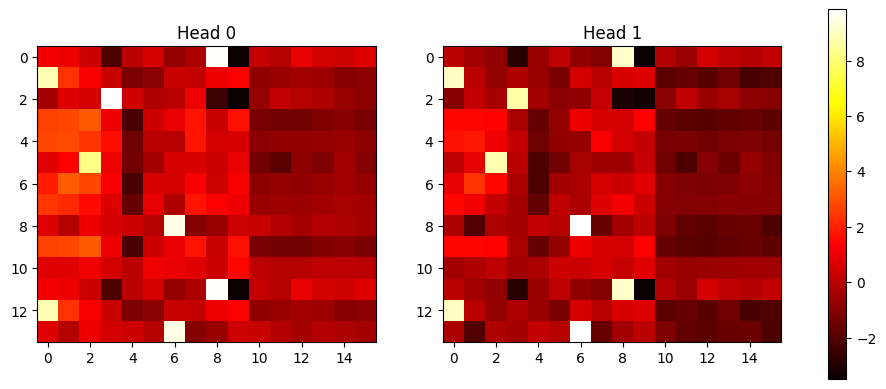

In [8]:
ex = gen_ex()
ex_toks = str_to_tokens(ex)
print(ex)
visualize_ov(ex_toks)

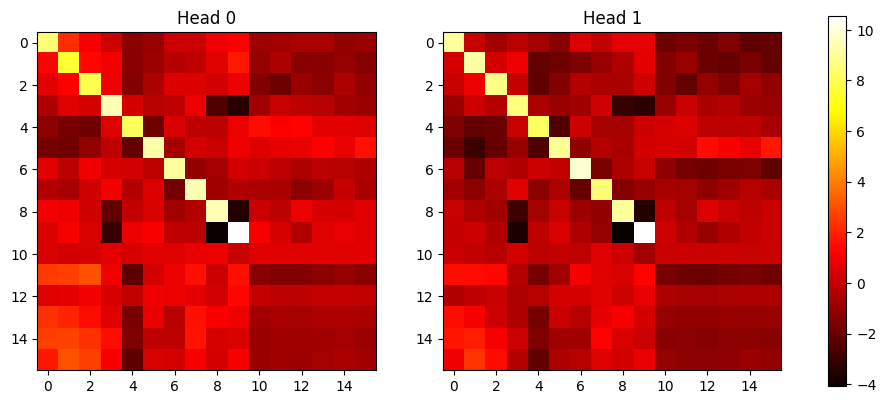

In [9]:
visualize_ov(range(16))

## Computing the copying behaviour

[Elhage et al](https://transformer-circuits.pub/2021/framework/index.html#splitting-attention-head-terms-into-circuits) proposes that copying behaviour in the OV circuit might be detectable by looking at the eigen values of the matrix. Where positive values mean that the model is performing copying.

Computing that metric we get values for each head that is inline with what they claim means copying behaviour, confirming our experiments

In [16]:
def copying_score():
    ov_circuit = model.embed.W_E @ model.OV @ model.unembed.W_U
    eigenvalues  = ov_circuit.eigenvalues
    copy_score = eigenvalues.sum(dim=-1).real / eigenvalues.abs().sum(dim=-1)
    return copy_score.detach().cpu()[0]

In [17]:
copying_score()

tensor([0.9447, 0.9405])

# Conclusion
Looking at the heads of the different circuits you can get a clear picture of how the model solves the task. It is clear that most of the "work" is performed inside of the QK circuit where information is moved around and the OV circuit is not performing any complex activation patterns, instead just strengthing the activation of the current number token and suppressing the special tokens.

## Further work
One interesting expansion of this problem is to increase the list length and allow for multiple indexing replacements. The interesting question here is whether a two head single layer model can still perform this task or if one head per index is required (plus one copying head)?